# Sawyer Jacobson
## Data Science Capstone, Final Project
## Using Machine Learning to Predict NHL Game Outcomes

### 5/22/2021

This project will use data scraped from the NHL statsapi on the overall team and player levels to predict the outcome of regular season NHL games. 
This is a binary classification problem so the appropriate algorithms will be used. I am particularly interested in obtaining the probability of 
winning for a team in the game. The target for predictions will be whether or not the home team won/will win and the associated probabilities.

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import plotnine
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy
from sklearn import metrics
import sklearn as sk
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
player_stats = pd.read_csv("data/game_player_stats.csv")
goalie_stats = pd.read_csv("data/game_goalie_stats.csv")
game_results = pd.read_csv("data/game_results.csv")
team_stats_game = pd.read_csv("data/game_team_stats.csv")
officials_game = pd.read_csv("data/game_officials.csv")

## setting the ID columns to characters
# game results IDs
game_ID_cols = game_results.filter(like="ID").columns.to_list()
game_results[game_ID_cols] = game_results[game_ID_cols].astype(str)

# team stats IDs
ID_cols = team_stats_game.filter(like="ID").columns.to_list()
team_stats_game[ID_cols] = team_stats_game[ID_cols].astype(str)

# player stats IDs
player_ID_cols = player_stats.filter(like="ID").columns.to_list()
player_stats[player_ID_cols] = player_stats[player_ID_cols].astype(str)

# goalie stats IDs
goalie_ID_cols = goalie_stats.filter(like="ID").columns.to_list()
goalie_stats[goalie_ID_cols] = goalie_stats[goalie_ID_cols].astype(str)

# dropping periods played column. Not going to do much good right now
team_stats_game.drop(columns="periodsPlayed", inplace=True)

# converting game dateTime to a date
game_results["dateTime"] = pd.to_datetime(game_results.dateTime).dt.date

player_stats.shape
goalie_stats.shape
game_results.shape
team_stats_game.shape
officials_game.shape

(422016, 27)

(25252, 24)

(11913, 12)

(23823, 17)

(46897, 3)

## Exploratory data analysis

First we'll check to see that all the data game in in the proper format. Some of the player ice time columns will need to be fixed using the function used for the player analysis project.

Also check to see what data is missing. Since I collected the data in a specific manner, missing data should be just the absence of data and in most cases will mean 0, False, whatever is the appropriate base case for that type of variable.

Since our interest is in the game data, let's see how the games are distributed in terms of results and scoring.

In [3]:
pd.set_option("max_info_columns", player_stats.shape[1])
pd.set_option("max_columns", player_stats.shape[1])

# checking the data types of each column to see what else needs to be cleaned
player_stats.info()
goalie_stats.info()
game_results.info()
team_stats_game.info()
officials_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422016 entries, 0 to 422015
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gameID                422016 non-null  object 
 1   playerID              422016 non-null  object 
 2   fullName              422016 non-null  object 
 3   position              422016 non-null  object 
 4   homeAway              422016 non-null  object 
 5   teamID                422016 non-null  object 
 6   teamName              422016 non-null  object 
 7   timeOnIce             422016 non-null  object 
 8   assists               422016 non-null  int64  
 9   goals                 422016 non-null  int64  
 10  shots                 422016 non-null  int64  
 11  hits                  422016 non-null  int64  
 12  powerPlayGoals        422016 non-null  int64  
 13  powerPlayAssists      422016 non-null  int64  
 14  penaltyMinutes        422016 non-null  int64  
 15  

Looks like everythink actually came in pretty clean! The time on ice variables need to be fixed as expected, but everything else came through nicely!

In [4]:
player_stats.columns

Index(['gameID', 'playerID', 'fullName', 'position', 'homeAway', 'teamID',
       'teamName', 'timeOnIce', 'assists', 'goals', 'shots', 'hits',
       'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins',
       'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals',
       'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce',
       'powerPlayTimeOnIce', 'shortHandedTimeOnIce', 'faceOffPct'],
      dtype='object')

In [5]:
# function to clean the time on ice from minutes:seconds format to a decimal
def clean_toi(x):
    time = x.str.split(":")
    minutes = time.str.get(0)
    seconds = time.str.get(1).astype(int)*100/60
    return minutes + "." + seconds.round().astype(int).astype(str)

time_on_ice_cols = ['timeOnIce', 'powerPlayTimeOnIce', 'evenTimeOnIce', 'shortHandedTimeOnIce']
# had to change the clean_toi function a few times because the list wasn't working right...
player_stats[time_on_ice_cols] = player_stats[time_on_ice_cols].apply(clean_toi).astype(float)

In [6]:
game_results.head()

,gameID,season,dateTime,gameType,homeTeamID,homeTeamName,awayTeamID,awayTeamName,homeGoals,awayGoals,homeTeamWin,venue
0,2010020001,20102011,2010-10-07,R,10,Toronto Maple Leafs,8,Montréal Canadiens,3,2,True,Air Canada Centre
1,2010020002,20102011,2010-10-07,R,5,Pittsburgh Penguins,4,Philadelphia Flyers,2,3,False,CONSOL Energy Center
2,2010020003,20102011,2010-10-07,R,30,Minnesota Wild,12,Carolina Hurricanes,3,4,False,Hartwall Areena
3,2010020004,20102011,2010-10-08,R,21,Colorado Avalanche,16,Chicago Blackhawks,4,3,True,Pepsi Center
4,2010020005,20102011,2010-10-08,R,22,Edmonton Oilers,20,Calgary Flames,4,0,True,Rexall Place


True     0.535046
False    0.464954
Name: homeTeamWin, dtype: float64

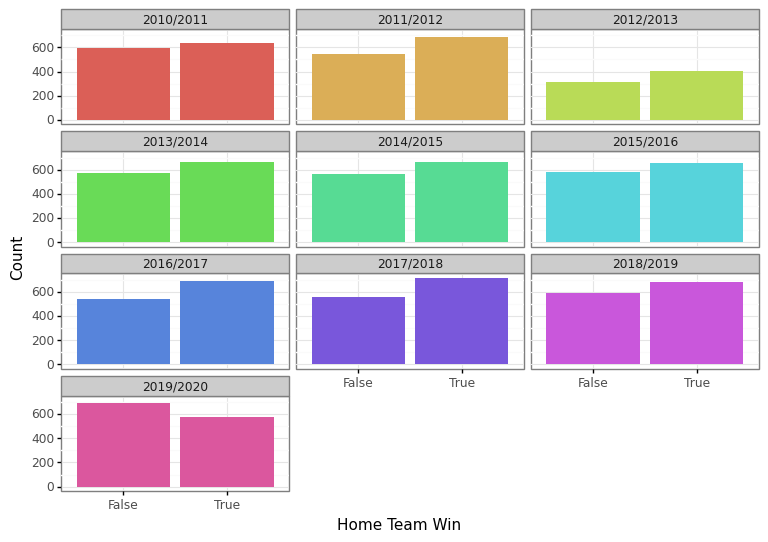

<ggplot: (366026153)>

In [7]:
# percentage of games where the home team won
game_results.homeTeamWin.value_counts()/game_results.shape[0]

def add_season(df):
    return df['gameID'].astype(str).str[0:4] + "/" + (df['gameID'].astype(str).str[0:4].astype(int) + 1).astype(str)

# adding a season column
game_results["season"] = add_season(game_results)#game_results['gameID'].astype(str).str[0:4] + "/" + (game_results['gameID'].astype(str).str[0:4].astype(int) + 1).astype(str)

plotnine.options.figure_size = (9, 6)

(
ggplot(game_results, aes(x = "homeTeamWin", fill = 'season')) + 
    geom_bar() + 
    theme_bw() + 
    facet_wrap(" ~ season", ncol = 3) +
    scale_fill_discrete(guide=False) +
    labs(x = "Home Team Win", y = "Count")
)

In [8]:
pd.crosstab(index=game_results['season'], columns=game_results['homeTeamWin'])

homeTeamWin,False,True
season,,
2010/2011,592,638
2011/2012,543,687
2012/2013,311,409
2013/2014,570,660
2014/2015,564,666
2015/2016,579,651
2016/2017,542,688
2017/2018,555,716
2018/2019,589,682


In almost every season from the past decade, the home team has won a slight majority of the games. The 2019/2020 season seemed to be the exception, potentially due to the season being delayed and cut short because of COVID-19.

Below, we'll create a new dataset that has a teams cumulative statistics throughout a season. These stats will be used as features in the predictive model. The difference between 2 teams cumulative stats up to the desired game in a season will be used (home team - away team) which should help determine which team is doing better in that season as well as a certain difference in performance. I intend to include other features such as whether the starter goalie has played consecutive games or not and also take into account the roster for each team. This last feature will be something of a pseudo roster strength going into the game. Theoretically this should help because the roster strength would be diminished if a star player was out hurt or something.

In [9]:
team_stats_game['season'] = add_season(team_stats_game)

In [10]:
team_stats_game['gamesPlayed'] = 1
team_num_vars = team_stats_game.select_dtypes(include = ['float64', 'int64']).columns.to_list()

# creating cumulative totals for the 
cum_team_num_stats = team_stats_game \
    .groupby(by=['teamID', 'season'])[team_num_vars] \
    .cumsum()
# creating the full cumulative team stats dataframe
cum_team_stats = pd.concat([team_stats_game.drop(columns=team_num_vars), cum_team_num_stats], axis="columns")
team_percent_cols = cum_team_stats.filter(like="Percentage").columns.to_list()
cum_team_stats[team_percent_cols] = cum_team_stats[team_percent_cols].apply(lambda x: x/cum_team_stats["gamesPlayed"])

# adding win and losing streaks to the team stats
def win_streak(df):
    win_streak=0
    df["winStreak"] = 0
    for index, row in df.iterrows():
        if (df.loc[index, "homeAway"] == "home" and df.loc[index, "homeTeamWin"]) or (df.loc[index, "homeAway"] == "away" and not df.loc[index, "homeTeamWin"]):
            win_streak+=1
            df.loc[index, "winStreak"] = win_streak
        else:
            win_streak=0
            df.loc[index, "winStreak"] = win_streak
    return(df)

def lose_streak(df):
    lose_streak=0
    df["loseStreak"] = 0
    for index, row in df.iterrows():
        if (df.loc[index, "homeAway"] == "home" and not df.loc[index, "homeTeamWin"]) or (df.loc[index, "homeAway"] == "away" and df.loc[index, "homeTeamWin"]):
            lose_streak+=1
            df.loc[index, "loseStreak"] = lose_streak
        else:
            lose_streak=0
            df.loc[index, "loseStreak"] = lose_streak
    return(df)

# adding win streak column
cum_team_stats = cum_team_stats \
    .groupby(['teamID', "season"]) \
    .apply(win_streak)

# adding losing streak column
cum_team_stats = cum_team_stats \
    .groupby(['teamID', "season"]) \
    .apply(lose_streak)

In [11]:
cum_team_stats

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak
0,2010020001,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3,6,24,0.000000,0.0,5.0,46.500000,22,6,16,27,1,1,0
1,2010020001,away,True,Jacques Martin,8,Montréal Canadiens,2010/2011,2,10,28,0.000000,0.0,3.0,53.500000,21,7,7,34,1,0,1
2,2010020002,home,False,Dan Bylsma,5,Pittsburgh Penguins,2010/2011,2,10,31,20.000000,1.0,5.0,60.700000,14,9,11,32,1,0,1
3,2010020002,away,False,Peter Laviolette,4,Philadelphia Flyers,2010/2011,3,12,27,25.000000,1.0,4.0,39.300000,16,1,9,34,1,1,0
4,2010020003,home,False,Todd Richards,30,Minnesota Wild,2010/2011,3,10,29,40.000000,2.0,5.0,61.200000,19,8,11,19,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23818,2019021269,away,False,Peter DeBoer,54,Vegas Golden Knights,2019/2020,224,566,2450,18.269512,42.0,191.0,43.342683,955,682,606,1906,82,4,0
23819,2019021270,home,False,Todd McLellan,26,Los Angeles Kings,2019/2020,177,479,2325,16.126829,33.0,193.0,43.543902,861,365,691,1460,82,0,1
23820,2019021270,away,False,Rick Bowness,25,Dallas Stars,2019/2020,178,568,2113,17.307317,42.0,199.0,43.614634,1031,533,825,1538,82,3,0
23821,2019021271,home,False,Bob Boughner,28,San Jose Sharks,2019/2020,180,723,2101,14.020732,33.0,189.0,41.570732,936,587,634,1587,82,0,2


In [12]:
cum_team_stats.query("season == '2010/2011' & gamesPlayed == 1")

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak
0,2010020001,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3,6,24,0.0,0.0,5.0,46.5,22,6,16,27,1,1,0
1,2010020001,away,True,Jacques Martin,8,Montréal Canadiens,2010/2011,2,10,28,0.0,0.0,3.0,53.5,21,7,7,34,1,0,1
2,2010020002,home,False,Dan Bylsma,5,Pittsburgh Penguins,2010/2011,2,10,31,20.0,1.0,5.0,60.7,14,9,11,32,1,0,1
3,2010020002,away,False,Peter Laviolette,4,Philadelphia Flyers,2010/2011,3,12,27,25.0,1.0,4.0,39.3,16,1,9,34,1,1,0
4,2010020003,home,False,Todd Richards,30,Minnesota Wild,2010/2011,3,10,29,40.0,2.0,5.0,61.2,19,8,11,19,1,0,1
5,2010020003,away,False,Paul Maurice,12,Carolina Hurricanes,2010/2011,4,10,31,40.0,2.0,5.0,38.8,19,3,11,14,1,1,0
6,2010020004,home,True,Joe Sacco,21,Colorado Avalanche,2010/2011,4,14,41,33.3,1.0,3.0,53.3,16,12,11,18,1,1,0
7,2010020004,away,True,Joel Quenneville,16,Chicago Blackhawks,2010/2011,3,6,38,28.6,2.0,7.0,46.7,10,16,3,19,1,0,1
8,2010020005,home,True,Tom Renney,22,Edmonton Oilers,2010/2011,4,28,33,33.3,2.0,6.0,51.7,20,11,16,27,1,1,0
9,2010020005,away,True,Brent Sutter,20,Calgary Flames,2010/2011,0,32,37,0.0,0.0,4.0,48.3,17,6,12,22,1,0,1


Here, the same process will be used to create a cumulative player stats dataset for each season.

In [13]:
player_stats["season"] = add_season(player_stats)
player_stats["gamesPlayed"] = 1
player_stats[['faceoffTaken', "faceOffWins", "faceOffPct"]] = player_stats[['faceoffTaken', "faceOffWins", "faceOffPct"]].fillna(value=0)
player_num_vars = player_stats.select_dtypes(include = ['float64', 'int64']).columns.to_list()

# adding a point streak column for players
def point_streak(df):
    point_streak=0
    df["pointStreak"] = 0
    for index, row in df.iterrows():
        if (df.loc[index, "assists"] > 0 or df.loc[index, 'goals'] > 0):
            point_streak+=1
            df.loc[index, "pointStreak"] = point_streak
        else:
            point_streak=0
            df.loc[index, "pointStreak"] = point_streak
    return(df)

# adding player point streak column
player_stats = player_stats \
    .groupby(['playerID', 'season']) \
    .apply(point_streak)

player_stats.head()

,gameID,playerID,fullName,position,homeAway,teamID,teamName,timeOnIce,assists,goals,shots,hits,powerPlayGoals,...,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,powerPlayTimeOnIce,shortHandedTimeOnIce,faceOffPct,season,gamesPlayed,pointStreak
0,2010020001,8468778,Colton Orr,R,home,10,Toronto Maple Leafs,3.32,0,0,0,2,0,...,0,0,0,0,0,1,3.32,0.00,0.00,0.0,2010/2011,1,0
1,2010020001,8470602,Dion Phaneuf,D,home,10,Toronto Maple Leafs,23.75,1,0,2,2,0,...,0,1,0,0,3,1,15.18,6.78,1.78,0.0,2010/2011,1,1
2,2010020001,8465200,Tomas Kaberle,D,home,10,Toronto Maple Leafs,23.92,0,0,2,1,0,...,0,0,0,0,2,0,16.27,7.65,0.00,0.0,2010/2011,1,0
3,2010020001,8467400,Francois Beauchemin,D,home,10,Toronto Maple Leafs,22.35,0,0,1,3,0,...,1,2,0,0,3,0,15.70,3.42,3.23,0.0,2010/2011,1,0
4,2010020001,8474125,Carl Gunnarsson,D,home,10,Toronto Maple Leafs,17.55,0,0,1,1,0,...,1,3,0,0,2,1,13.32,1.47,2.77,0.0,2010/2011,1,0


In [14]:
# creating cumulative totals for the 
cum_player_num_stats = player_stats \
    .groupby(by=['playerID', 'season'])[player_num_vars] \
    .cumsum()
# creating the full cumulative team stats dataframe
cum_player_stats = pd.concat([player_stats.drop(columns=player_num_vars), cum_player_num_stats], axis="columns")



In [15]:
cum_player_stats

,gameID,playerID,fullName,position,homeAway,teamID,teamName,season,pointStreak,timeOnIce,assists,goals,shots,...,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,powerPlayTimeOnIce,shortHandedTimeOnIce,faceOffPct,gamesPlayed
0,2010020001,8468778,Colton Orr,R,home,10,Toronto Maple Leafs,2010/2011,0,3.32,0,0,0,...,0,0,0,0,0,0,0,1,3.32,0.00,0.00,0.00,1
1,2010020001,8470602,Dion Phaneuf,D,home,10,Toronto Maple Leafs,2010/2011,1,23.75,1,0,2,...,0,0,0,1,0,0,3,1,15.18,6.78,1.78,0.00,1
2,2010020001,8465200,Tomas Kaberle,D,home,10,Toronto Maple Leafs,2010/2011,0,23.92,0,0,2,...,0,0,0,0,0,0,2,0,16.27,7.65,0.00,0.00,1
3,2010020001,8467400,Francois Beauchemin,D,home,10,Toronto Maple Leafs,2010/2011,0,22.35,0,0,1,...,0,0,1,2,0,0,3,0,15.70,3.42,3.23,0.00,1
4,2010020001,8474125,Carl Gunnarsson,D,home,10,Toronto Maple Leafs,2010/2011,0,17.55,0,0,1,...,0,0,1,3,0,0,2,1,13.32,1.47,2.77,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422011,2019021082,8478469,Thomas Chabot,D,away,9,Ottawa Senators,2019/2020,0,1849.07,33,6,186,...,0,0,42,87,0,0,85,-18,1599.77,233.27,19.48,0.00,71
422012,2019021082,8477963,Jayce Hawryluk,R,away,9,Ottawa Senators,2019/2020,1,289.16,7,3,26,...,4,12,11,12,0,0,9,1,285.67,4.27,0.40,300.00,26
422013,2019021082,8478870,Rudolfs Balcers,L,away,9,Ottawa Senators,2019/2020,0,183.54,2,1,23,...,0,2,7,5,0,0,7,-2,159.19,26.07,0.00,0.00,15
422014,2019021082,8476285,Matthew Peca,C,away,9,Ottawa Senators,2019/2020,0,146.19,2,0,7,...,43,79,0,1,0,0,4,-4,138.00,1.48,8.78,619.38,14


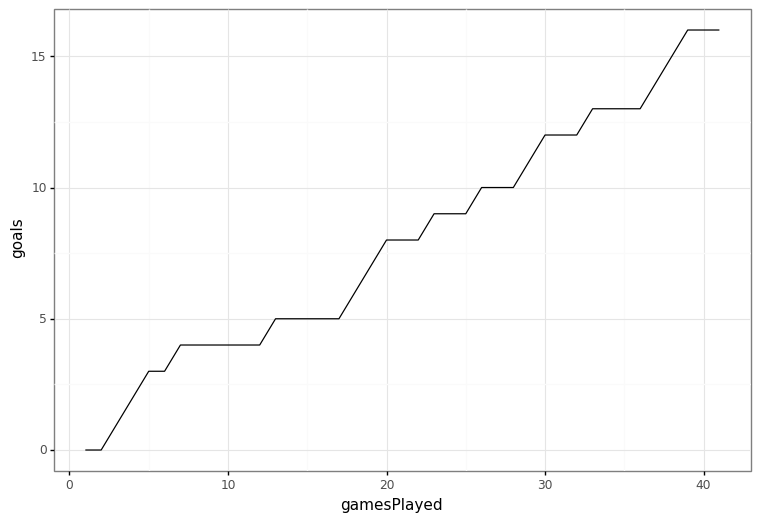

<ggplot: (351895474)>

In [16]:
(
ggplot(cum_player_stats.query("fullName == 'Sidney Crosby' & season == '2019/2020'"), aes(x = "gamesPlayed", y = "goals")) + 
    geom_line() + 
    theme_bw()
)

Lastly we'll do the same cumulative stats for goalies.


In [17]:
goalie_stats.columns

Index(['gameID', 'playerID', 'fullName', 'position', 'homeAway', 'teamID',
       'teamName', 'timeOnIce', 'assists', 'goals', 'pim', 'shots', 'saves',
       'powerPlaySaves', 'shortHandedSaves', 'evenSaves',
       'shortHandedShotsAgainst', 'evenShotsAgainst', 'powerPlayShotsAgainst',
       'decision', 'savePercentage', 'powerPlaySavePercentage',
       'shortHandedSavePercentage', 'evenStrengthSavePercentage'],
      dtype='object')

In [18]:
goalie_stats["season"] = add_season(goalie_stats)
goalie_stats["gamesPlayed"] = 1
goalie_num_vars = goalie_stats.select_dtypes(include = ['float64', 'int64']).columns.to_list()

# creating cumulative totals for the 
cum_goalie_num_stats = goalie_stats \
    .groupby(by=['playerID', 'season'])[goalie_num_vars] \
    .cumsum()
# creating the full cumulative team stats dataframe
cum_goalie_stats = pd.concat([goalie_stats.drop(columns=goalie_num_vars), cum_goalie_num_stats], axis="columns")

save_percentages = ["savePercentage", "powerPlaySavePercentage", "shortHandedSavePercentage", "evenStrengthSavePercentage"]

cum_goalie_stats[save_percentages] = cum_goalie_stats[save_percentages].fillna(value=0).apply(lambda x: x/cum_goalie_stats["gamesPlayed"])

In [19]:
cum_goalie_stats

,gameID,playerID,fullName,position,homeAway,teamID,teamName,timeOnIce,decision,season,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,savePercentage,powerPlaySavePercentage,shortHandedSavePercentage,evenStrengthSavePercentage,gamesPlayed
0,2010020001,8462044,Jean-Sebastien Giguere,G,home,10,Toronto Maple Leafs,58:49,W,2010/2011,0,0,0,28,26,3,2,21,2,23,3,92.857143,100.000000,100.000000,91.304348,1
1,2010020001,8471679,Carey Price,G,away,8,Montréal Canadiens,58:59,L,2010/2011,0,0,0,24,21,2,0,19,0,22,2,87.500000,100.000000,0.000000,86.363636,1
2,2010020002,8470594,Marc-Andre Fleury,G,home,5,Pittsburgh Penguins,58:47,L,2010/2011,0,0,0,27,24,3,1,20,2,21,4,88.888889,75.000000,50.000000,95.238095,1
3,2010020002,8475683,Sergei Bobrovsky,G,away,4,Philadelphia Flyers,60:00,W,2010/2011,0,0,0,31,29,3,1,25,1,26,4,93.548387,75.000000,100.000000,96.153846,1
4,2010020003,8473404,Niklas Backstrom,G,home,30,Minnesota Wild,58:45,L,2010/2011,0,0,0,31,27,1,1,25,1,27,3,87.096774,33.333333,100.000000,92.592593,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25247,2019021080,8476945,Connor Hellebuyck,G,away,52,Winnipeg Jets,60:00,W,2019/2020,2,0,0,1796,1656,189,49,1418,50,1530,216,90.738610,75.395457,0.000000,91.105086,58
25248,2019021081,8480925,Pavel Francouz,G,home,21,Colorado Avalanche,62:50,W,2019/2020,0,0,2,996,919,114,34,771,34,837,125,89.236823,84.517974,52.941176,88.852794,34
25249,2019021081,8480382,Alexandar Georgiev,G,away,3,New York Rangers,61:44,L,2019/2020,1,0,0,1063,967,175,27,765,29,837,197,89.961725,86.220373,46.323529,90.400529,34
25250,2019021082,8477361,Calvin Petersen,G,home,26,Los Angeles Kings,59:34,W,2019/2020,0,0,0,269,248,34,8,206,8,224,37,91.883237,92.261905,75.000000,91.417911,8


In [20]:
cum_team_stats

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak
0,2010020001,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3,6,24,0.000000,0.0,5.0,46.500000,22,6,16,27,1,1,0
1,2010020001,away,True,Jacques Martin,8,Montréal Canadiens,2010/2011,2,10,28,0.000000,0.0,3.0,53.500000,21,7,7,34,1,0,1
2,2010020002,home,False,Dan Bylsma,5,Pittsburgh Penguins,2010/2011,2,10,31,20.000000,1.0,5.0,60.700000,14,9,11,32,1,0,1
3,2010020002,away,False,Peter Laviolette,4,Philadelphia Flyers,2010/2011,3,12,27,25.000000,1.0,4.0,39.300000,16,1,9,34,1,1,0
4,2010020003,home,False,Todd Richards,30,Minnesota Wild,2010/2011,3,10,29,40.000000,2.0,5.0,61.200000,19,8,11,19,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23818,2019021269,away,False,Peter DeBoer,54,Vegas Golden Knights,2019/2020,224,566,2450,18.269512,42.0,191.0,43.342683,955,682,606,1906,82,4,0
23819,2019021270,home,False,Todd McLellan,26,Los Angeles Kings,2019/2020,177,479,2325,16.126829,33.0,193.0,43.543902,861,365,691,1460,82,0,1
23820,2019021270,away,False,Rick Bowness,25,Dallas Stars,2019/2020,178,568,2113,17.307317,42.0,199.0,43.614634,1031,533,825,1538,82,3,0
23821,2019021271,home,False,Bob Boughner,28,San Jose Sharks,2019/2020,180,723,2101,14.020732,33.0,189.0,41.570732,936,587,634,1587,82,0,2


In [21]:
cum_team_num_vars = cum_team_stats.select_dtypes(include = ['float64', 'int64']).columns.to_list()

shifted_team_stats = cum_team_stats.groupby(['teamID', "season"])[cum_team_num_vars].shift(1)
short_team_stats = cum_team_stats.drop(columns=cum_team_num_vars)#.groupby(['teamID', "season"])[cum_team_num_vars].shift(1)

proper_team_stats = pd.concat([short_team_stats, shifted_team_stats], axis="columns").dropna()

# cum_team_stats.groupby(['teamID', "season"]).shift(1).dropna()

In [22]:
proper_team_stats.head()

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak
14,2010020008,home,True,Paul Maurice,12,Carolina Hurricanes,2010/2011,4.0,10.0,31.0,40.0,2.0,5.0,38.8,19.0,3.0,11.0,14.0,1.0,1.0,0.0
15,2010020008,away,True,Todd Richards,30,Minnesota Wild,2010/2011,3.0,10.0,29.0,40.0,2.0,5.0,61.2,19.0,8.0,11.0,19.0,1.0,0.0,1.0
24,2010020013,home,False,Lindy Ruff,7,Buffalo Sabres,2010/2011,2.0,12.0,36.0,20.0,1.0,5.0,43.4,20.0,5.0,8.0,22.0,1.0,1.0,0.0
26,2010020014,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3.0,6.0,24.0,0.0,0.0,5.0,46.5,22.0,6.0,16.0,27.0,1.0,1.0,0.0
27,2010020014,away,True,Cory Clouston,9,Ottawa Senators,2010/2011,1.0,12.0,26.0,0.0,0.0,5.0,56.6,7.0,16.0,18.0,26.0,1.0,0.0,1.0


In [23]:
home_team = proper_team_stats.query("homeAway == 'home'").sort_values('gameID').reset_index().drop(columns="index")

In [24]:
away_team = proper_team_stats.query("homeAway == 'away'").sort_values('gameID').reset_index().drop(columns="index")

In [25]:
full_gameID_stats = pd.merge(home_team.gameID, away_team.gameID, how="inner")
full_gameID_stats['gameID'] = full_gameID_stats.gameID.astype(str)
home_team_clean = pd.merge(home_team, full_gameID_stats, how="inner", on="gameID")
away_team_clean = pd.merge(away_team, full_gameID_stats, how="inner", on="gameID")

prior_game_stats = pd.concat([full_gameID_stats, home_team_clean[cum_team_num_vars].subtract(away_team_clean[cum_team_num_vars])], axis="columns")

In [29]:
prediction_df = pd.merge(game_results.filter(items=['gameID', 'season', "homeTeamWin"]), prior_game_stats, how = "inner", on="gameID")


In [32]:
prediction_df['homeTeamWin'] = prediction_df.homeTeamWin.astype(int)

In [33]:
prediction_df

,gameID,season,homeTeamWin,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak
0,2010020008,2010/2011,1,1.0,0.0,2.0,0.000000,0.0,0.0,-22.400000,0.0,-5.0,0.0,-5.0,0.0,1.0,-1.0
1,2010020014,2010/2011,1,2.0,-6.0,-2.0,0.000000,0.0,0.0,-10.100000,15.0,-10.0,-2.0,1.0,0.0,1.0,-1.0
2,2010020016,2010/2011,0,0.0,0.0,3.0,20.000000,1.0,2.0,7.200000,-7.0,2.0,4.0,-2.0,0.0,0.0,0.0
3,2010020017,2010/2011,1,-1.0,4.0,1.0,-100.000000,-1.0,2.0,7.900000,4.0,11.0,0.0,9.0,0.0,0.0,0.0
4,2010020021,2010/2011,0,-1.0,-20.0,-5.0,28.600000,2.0,1.0,-18.100000,2.0,6.0,-5.0,-2.0,0.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11728,2019021267,2019/2020,0,-6.0,58.0,210.0,-4.380247,-7.0,10.0,3.479012,52.0,75.0,179.0,36.0,0.0,-2.0,0.0
11729,2019021268,2019/2020,0,-19.0,38.0,112.0,-5.939506,-18.0,-7.0,-0.533333,-128.0,21.0,-21.0,-310.0,0.0,0.0,-4.0
11730,2019021269,2019/2020,0,0.0,77.0,-297.0,1.634568,14.0,45.0,2.148148,133.0,-207.0,-32.0,-546.0,0.0,-1.0,0.0
11731,2019021270,2019/2020,0,-1.0,-89.0,212.0,-1.195062,-9.0,-6.0,-0.071605,-170.0,-168.0,-134.0,-78.0,0.0,-1.0,0.0


In [35]:
prediction_df.homeTeamWin.value_counts()

1    6280
0    5453
Name: homeTeamWin, dtype: int64

In [59]:
X_train, X_test = prediction_df.query('season != "2019/2020"').drop(columns=["gameID", "season", "homeTeamWin"]), prediction_df.query('season == "2019/2020"').drop(columns=["gameID", "season", "homeTeamWin"])

y_train, y_test = prediction_df.query('season != "2019/2020"')['homeTeamWin'], prediction_df.query('season == "2019/2020"')['homeTeamWin']

X_train.shape
y_train.shape
X_test.shape
y_test.shape

(10480, 14)

(10480,)

(1253, 14)

(1253,)

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

log_reg = LogisticRegression(max_iter=1e4)

log_reg.fit(X_train, y_train)

train_preds = log_reg.predict(X_train)
test_preds = log_reg.predict(X_test)

pd.crosstab(y_train, train_preds)
pd.crosstab(y_test, test_preds)

accuracy_score(y_train, train_preds)
accuracy_score(y_test, test_preds)

y_test.value_counts()/len(y_test)

print(classification_report(y_test, test_preds))

LogisticRegression(max_iter=10000.0)

col_0,0,1
homeTeamWin,,
0,1168,3598
1,926,4788


col_0,0,1
homeTeamWin,,
0,172,515
1,78,488


0.5683206106870229

0.5267358339984038

0    0.548284
1    0.451716
Name: homeTeamWin, dtype: float64

              precision    recall  f1-score   support

           0       0.69      0.25      0.37       687
           1       0.49      0.86      0.62       566

    accuracy                           0.53      1253
   macro avg       0.59      0.56      0.49      1253
weighted avg       0.60      0.53      0.48      1253



In [82]:
for var, coef in zip(X_train.columns.values, log_reg.coef_[0]):
    print(var, ": ", coef, sep='')

goals: 0.007830634978290639
pim: 0.0003649435621434153
shots: 0.0007873307190965081
powerPlayPercentage: 0.001400297688394481
powerPlayGoals: 0.004270337140958844
powerPlayOpportunities: -0.003340513295449435
faceOffWinPercentage: 0.01256996453809237
blocked: -0.0004914829449678179
takeaways: -0.0003835502229418106
giveaways: 1.5648155342200332e-05
hits: 1.3723271695827538e-05
gamesPlayed: -0.058243694441131345
winStreak: 0.012055112794701077
loseStreak: 2.4547803680252882e-05


In [81]:
log_reg.coef_[0]

array([ 7.83063498e-03,  3.64943562e-04,  7.87330719e-04,  1.40029769e-03,
        4.27033714e-03, -3.34051330e-03,  1.25699645e-02, -4.91482945e-04,
       -3.83550223e-04,  1.56481553e-05,  1.37232717e-05, -5.82436944e-02,
        1.20551128e-02,  2.45478037e-05])

In [80]:
X_train

,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak
0,1.0,0.0,2.0,0.000000,0.0,0.0,-22.400000,0.0,-5.0,0.0,-5.0,0.0,1.0,-1.0
1,2.0,-6.0,-2.0,0.000000,0.0,0.0,-10.100000,15.0,-10.0,-2.0,1.0,0.0,1.0,-1.0
2,0.0,0.0,3.0,20.000000,1.0,2.0,7.200000,-7.0,2.0,4.0,-2.0,0.0,0.0,0.0
3,-1.0,4.0,1.0,-100.000000,-1.0,2.0,7.900000,4.0,11.0,0.0,9.0,0.0,0.0,0.0
4,-1.0,-20.0,-5.0,28.600000,2.0,1.0,-18.100000,2.0,6.0,-5.0,-2.0,0.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10475,-4.0,-23.0,-68.0,-0.714815,-5.0,-28.0,2.306173,63.0,6.0,501.0,215.0,0.0,0.0,0.0
10476,62.0,-55.0,258.0,-3.475309,7.0,51.0,3.438272,-137.0,187.0,220.0,-954.0,0.0,0.0,-4.0
10477,-59.0,-178.0,-25.0,-8.856790,-20.0,7.0,-3.038272,101.0,-42.0,-56.0,188.0,0.0,1.0,-2.0
10478,-50.0,82.0,-457.0,-2.346914,-5.0,-12.0,0.323457,52.0,-478.0,99.0,-368.0,0.0,0.0,0.0


In [51]:
prediction_df.iloc[10476]

gameID                    2018021268
season                     2018/2019
homeTeamWin                        0
goals                      62.000000
pim                       -55.000000
shots                     258.000000
powerPlayPercentage        -3.475309
powerPlayGoals              7.000000
powerPlayOpportunities     51.000000
faceOffWinPercentage        3.438272
blocked                  -137.000000
takeaways                 187.000000
giveaways                 220.000000
hits                     -954.000000
gamesPlayed                 0.000000
winStreak                   0.000000
loseStreak                 -4.000000
Name: 10476, dtype: object

In [52]:
home_team.query("gameID == '2018021268'")

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak
10488,2018021268,home,False,Bill Peters,20,Calgary Flames,2018/2019,288.0,693.0,2625.0,19.498765,53.0,272.0,52.054321,1025.0,836.0,1168.0,1224.0,81.0,0.0,1.0


In [53]:
away_team.query("gameID == '2018021268'")

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak
10513,2018021268,away,False,Ken Hitchcock,22,Edmonton Oilers,2018/2019,226.0,748.0,2367.0,22.974074,46.0,221.0,48.616049,1162.0,649.0,948.0,2178.0,81.0,0.0,5.0


In [55]:
team_stats_game.query("gameID == '2018021268'")

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,season,gamesPlayed
21273,2018021268,home,False,Bill Peters,20,Calgary Flames,1,2,31,0.0,0.0,3.0,74.1,8,9,21,9,2018/2019,1
21274,2018021268,away,False,Ken Hitchcock,22,Edmonton Oilers,3,6,25,100.0,1.0,1.0,25.9,12,16,20,14,2018/2019,1
